In [43]:
import numpy as np
import matplotlib.pyplot as plt

In [74]:
class Catagorization:
    def __init__(self, num_ants, end_cond, data, attributes, options, classes):
        self.num_ants = num_ants
        self.end_cond = end_cond
        self.data = data
        self.attributes = attributes
        self.options = options
        self.classes = classes
        self.heuristic = self.calc_heuristic()
        self.pharamones = self.init_pharamones()
        self.discovered_rules = {}
        self.qualities = []
        
        self.ants = [Ant(self.pharamones, self.heuristic, self.attributes, self.options, self.classes) for i in range(num_ants)]
        
        
    def run_simulation(self):
        for ant in self.ants:
            self.run_one_ant(ant)
#             print(self.discovered_rules.items())
#             print('')
#             print('std is: ', np.std(list(self.pharamones.values())))
#             print(self.pharamones)
        
    def run_one_ant(self, ant):
        ant.pharamones = self.pharamones
        ant.add_terms()
        q = self.prune_ant(ant)
        consequent = self.calc_consequent(ant.rule)
        self.update_pharamones(ant.rule, q)
        self.discovered_rules[tuple(ant.rule)] = q
        self.qualities.append(q)
        
    def calc_heuristic(self):
        total_num = len(self.attributes)*len(self.options)*len(self.classes)
        probs = {}
        heuristic = {}
        for i in attributes:
            for j in options:
                for k in classes:
                    a = [game for game in data_listed if k == game[-1]]
                    b = [game for game in a if j == game[i]]
                    p = len(b)/len(data_listed)
                    c = probs.get((i,j),[]) 
                    c.append(np.log2(p**p))
                    probs[(i,j)] = c
                heuristic[(i,j)] = -sum(probs[(i,j)])
        return heuristic

    def pick_best_rule(self):
        most_correct = 0
        best_ant = None
        for ant in self.ants:
            consequence, num_correct = self.calc_num_correct(ant.rule)
            ant.consequence = consequence
            if num_correct > most_correct:
                most_correct = num_correct
                best_ant = ant
        return most_correct, best_ant
    
    def find_relevant_cases(self, rule):
        relevant_cases = self.data.copy()
        for case in self.data:
            for term in rule:
                if case[term[0]] != term[1]:
                    relevant_cases.remove(case)
                    break
        return relevant_cases
    
    def calc_consequent(self, rule):
        relevant_cases = self.find_relevant_cases(rule)
        classes = {}
        if not relevant_cases:
            relevant_cases = self.data
            
        for case in relevant_cases:
            classes[str(case[-1])] = classes.get(str(case[-1]), 0) + 1
        res = max(classes, key=classes.get)
        return res
    
    def prune_ant(self, ant):
        """Iteratively goes through the rulelist for an ant and sees which rules are not helping the quality of the rule"""
        while True:
            max_delta_quality = 0
            best_new_rule = ant.rule
            consequent = self.calc_consequent(ant.rule)
            base_quality = self.calc_quality(ant.rule, consequent)
            
            for i, term in enumerate(ant.rule):
                new_rule = ant.rule[0:i] + ant.rule[i+1:]
                new_consequent = self.calc_consequent(new_rule)
                new_quality = self.calc_quality(new_rule, new_consequent)
                if max_delta_quality < new_quality - base_quality:
                    max_delta_quality = new_quality - base_quality
                    best_new_rule = new_rule
            if max_delta_quality > 0:
                ant.rule = best_new_rule
                max_delta_quality = 0
            else:
                break
        return max_delta_quality + base_quality
        
    def calc_quality(self, rule, consequent):
        relevant_cases = self.find_relevant_cases(rule)
        num_cases_covered = len(relevant_cases)
        num_cases_not_covered = len(self.data) - len(relevant_cases)
        
        true_positives = len([case for case in relevant_cases if case[-1] == consequent])
        false_positives = len(relevant_cases) - true_positives
        false_negatives = len([case for case in self.data if case not in relevant_cases and case[-1] == consequent])
        true_negatives = len(self.data) - len(relevant_cases) - false_negatives
        
        sensitivity = true_positives / (true_positives + false_negatives)
        specificity = true_negatives / (true_negatives + false_positives)
        
        return sensitivity * specificity
        
    def run_sim(self):
        ants = {}
        ants['ant0'] = Ant(pharamones)
        for i in range(self.num_ants):
            ants["ant" + str(i)] = Ant(ants["ant" + str(i-1)].pharamones)
            
    def init_pharamones(self):
        pharamones = {}
        initial_value = 1/(len(self.attributes) * len(self.options))
        for i in attributes:
            for j in options:
                pharamones[(i,j)] = initial_value
        return pharamones
    
    def update_pharamones(self, rule, quality):
        for term in rule:
            self.pharamones[(term[0], term[1])] += quality
        normalization_factor = sum(self.pharamones.values())
        keys = self.pharamones.keys()
        for key in keys:
            self.pharamones[key] /= normalization_factor
        
        assert(sum(self.pharamones.values()) -1 < 0.0001)

In [46]:
class Ant:
    delta_p = .05
    def __init__(self,pharamones, heuristic, attributes, options, classes):
        ""
        self.rule = []
        self.pharamones = pharamones
        self.heuristic = heuristic
        self.decision = np.zeros((9,3))
        self.k = 2
        self.classes = classes
        self.attributes = attributes
        self.options = options
        self.used_attributes = []
        
    def add_terms(self):
        "adds a term to the ruleset based on the pharamone trail and heuristic function"
        for i in self.attributes:
            probs = self.calc_prob()
            picking = True
            while picking:
                term = self.pick_term(probs)
                if term[0] not in self.used_attributes:
                    self.used_attributes.append(term[0])
                    picking = False
            self.rule.append(term)
        
    def normalize(self, function):
        norm = {}
        for i in self.attributes:
            for j in self.options:
                num = function(i, j)
                if num == 0:
                    norm[(i,j)] = 0
                    continue
                unused_attributes = len(self.attributes)-len(self.rule)
                normalization_factor = 0
                for jj in self.options:
                    normalization_factor += function(i, jj)
                norm[(i,j)] = num / (unused_attributes * normalization_factor)
        return norm
        
    def normalize_heuristic(self):
        def f(i, j):
            return np.log2(self.k) - self.heuristic[(i,j)]
        return self.normalize(f)
    
    def calc_prob(self):
        self.normalized_heuristic = self.normalize_heuristic()
        def f(i, j):
            if i not in self.used_attributes:
                return self.pharamones[(i,j)] * self.normalized_heuristic[(i,j)]
            else:
                return 0
        return self.normalize(f)
    
    def pick_term(self, probs):
        index = np.random.choice(len(probs), 1, p = list(probs.values()))
        index = index[0]
        term = list(probs.keys())[index]
        return term


In [47]:
import os
data = open('../data/tic-tac-toe.data', 'r')
# data = open('../data/breast-cancer.data', 'r')
data_listed = []
#for i in range(0,957):
#    entry = []
#    for i in range(0,9):
#        continue
for i in data.readlines():
    data_listed.append(tuple(str.split(i[:-1], ',')))


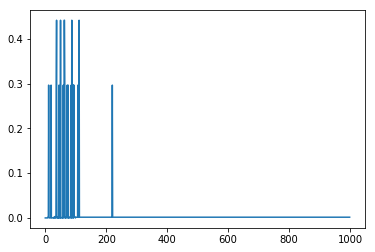

In [75]:
import numpy as np
attributes = list(range(0,9))
options = ['x','o','b']
classes = ['positive', 'negative']


s = Catagorization(1000, None, data_listed, attributes, options, classes)
# pharamones = s.pharamones
# h = s.heuristic
# aa = Ant(pharamones, h, attributes, options, classes)
s.run_simulation()
plt.plot(s.qualities)
plt.show()

In [14]:
a= [1,2,3,4,5]
for i in range(5):
    print(a[0:i-1+1]+a[i+1:])


[2, 3, 4, 5]
[1, 3, 4, 5]
[1, 2, 4, 5]
[1, 2, 3, 5]
[1, 2, 3, 4]


In [33]:
b = {'a': 4, 'b':3, 'c':19}
sum(b.values())
b['b'] /= 3
b

{'a': 4, 'b': 1.0, 'c': 19}